In [2]:
%pylab inline
from poorHighCost_copy import * 
Vgrid = np.load("poorHigh.npy")
matplotlib.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 15})

Populating the interactive namespace from numpy and matplotlib


NameError: name 'partial' is not defined

In [4]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.ndimage import map_coordinates
import warnings
from jax import jit, random, vmap
from tqdm import tqdm
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

# time line
T_min = 0
T_max = 60
T_R = 45
# discounting factor
beta = 1/(1+0.02)
# utility function parameter 
gamma = 4
# relative importance of housing consumption and non durable consumption 
alpha = 0.7
# parameter used to calculate the housing consumption 
kappa = 0.3
# uB associated parameter
B = 2
# social welfare after the unemployment
welfare = 20
# tax rate before and after retirement
tau_L = 0.2
tau_R = 0.1
# number of states S
nS = 8
# number of states e
nE = 2
# housing state
nO = 2
# experience state 
nZ = 2


'''
    Economic state calibration 
'''

# probability of survival
Pa = jnp.array(np.load("constant/prob.npy"))
# deterministic income
detEarning = jnp.array(np.load("constant/detEarningHigh.npy"))
# rescale the deterministic income
detEarning = detEarning 
####################################################################################### low skill feature
detEarning = jnp.concatenate([detEarning[:46]*0.5, detEarning[46:]-45])
# Define transition matrix of economical states S
Ps = np.genfromtxt('constant/Ps.csv',delimiter=',')
fix = (np.sum(Ps, axis = 1) - 1)
for i in range(nS):
    for j in range(nS):
        if Ps[i,j] - fix[i] > 0:
            Ps[i,j] = Ps[i,j] - fix[i]
            break
Ps = jnp.array(Ps)
# The possible GDP growth, stock return, bond return
gkfe = np.genfromtxt('constant/gkfe.csv',delimiter=',')
gkfe = jnp.array(gkfe)
# GDP growth depending on current S state
gGDP = gkfe[:,0]/100
# risk free interest rate depending on current S state 
r_b = gkfe[:,1]/100
# stock return depending on current S state
r_k = gkfe[:,2]/100
# unemployment rate depending on current S state 
Pe = gkfe[:,7:]/100
Pe = Pe[:,::-1]

'''
    401k related constants
'''
# some variables associated with 401k amount
r_bar = 0.02
Pa = Pa[:T_max]
Nt = [np.sum(Pa[t:]) for t in range(T_min,T_max)]
#Factor used to calculate the withdraw amount 
Dn = [(r_bar*(1+r_bar)**N)/((1+r_bar)**N - 1) for N in Nt]
Dn[-1] = 1
Dn = jnp.array(Dn)
# income fraction goes into 401k 
yi = 0.04



'''
    housing related constants
'''
# variable associated with housing and mortgage 
# mortgage rate 
rh = 0.045
# housing unit
H = 600
# rent unit
Rl = 300
# housing price constant 
pt = 2*250/1000
# 30k rent 1000 sf
pr = 2*10/1000 * 2 
# constant cost 
c_h = 5
c_s = H*pt*0.4
# Dm is used to update the mortgage payment
Dm = [(1+rh) - rh*(1+rh)**(T_max - t)/((1+rh)**(T_max-t)-1) for t in range(T_min, T_max)]
Dm[-1] = 0
Dm = jnp.array(Dm)

# 30 year mortgage
Ms = []
M = H*pt*0.8
m = M*(1+rh) - Dm[30]*M
for i in range(30, T_max):
    M = M*(1+rh) - m
    Ms.append(M)
Ms[-1] = 0
Ms = jnp.array(Ms)

############################################################################################################ low skill feature 
# stock transaction fee
Kc = 0.02

# stock participation cost
c_k = 20


'''
    Discretize the state space
    Discretize the action space 
'''
# actions dicretization(hp, cp, kp)
numGrid = 20
As = np.array(np.meshgrid(np.linspace(0.001,0.999,numGrid), np.linspace(0,1,numGrid), [0,1])).T.reshape(-1,3)
As = jnp.array(As)
# wealth discretization 
ws = np.linspace(0, 400, 20)
ns = np.linspace(0, 300, 10)
ms = np.linspace(0, 0.8*H*pt, 10)
# scales associated with discretization
scaleW = ws.max()/ws.size
scaleN = ns.max()/ns.size
scaleM = ms.max()/ms.size

# dimentions of the state
dim = (ws.size, ns.size, ms.size, nS, nE, nO, nZ)
dimSize = len(dim)

xgrid = np.array([[w,n,m,s,e,o,k] for w in ws
                            for n in ns
                            for m in ms
                            for s in range(nS)
                            for e in range(nE)
                            for o in range(nO)
                            for k in range(nZ)]).reshape(dim + (dimSize,))

Xs = xgrid.reshape((np.prod(dim),dimSize))
Xs = jnp.array(Xs)

Vgrid = np.zeros(dim + (T_max,))
cgrid = np.zeros(dim + (T_max,))
bgrid = np.zeros(dim + (T_max,))
kgrid = np.zeros(dim + (T_max,))
hgrid = np.zeros(dim + (T_max,))
agrid = np.zeros(dim + (T_max,))

# start of function definitions
nX = Xs.shape[0]
nA = As.shape[0]

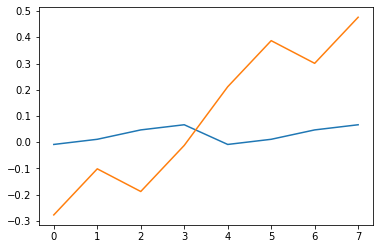

In [7]:
plt.plot(r_b)
plt.plot(r_k)

In [9]:
r_b

DeviceArray([-0.00841847,  0.01124221,  0.04698699,  0.06664767,
             -0.00841847,  0.01124221,  0.04698699,  0.06664767],            dtype=float32)

In [11]:
r_k.mean()

DeviceArray(0.09970161, dtype=float32)

In [14]:
jnp.std(r_k)

DeviceArray(0.2633825, dtype=float32)

In [2]:
num = 10000
'''
    x = [w,n,m,s,e,o,z]
    x = [5,0,0,0,0,0,0]
'''

from jax import random

def simulation(key):
    initE = random.choice(a = nE, p=E_distribution, key = key)
    initS = random.choice(a = nS, p=S_distribution, key = key)
    x = [5, 0, 0, initS, initE, 0, 0]
    path = []
    move = []
    for t in range(T_min, T_max):
        _, key = random.split(key)
        if t == T_max-1:
            _,a = V(t,Vgrid[:,:,:,:,:,:,:,t],x)
        else:
            _,a = V(t,Vgrid[:,:,:,:,:,:,:,t+1],x)
        xp = transition(t,a.reshape((1,-1)),x)
        p = xp[:,-1]
        x_next = xp[:,:-1]
        path.append(x)
        move.append(a)
        x = x_next[random.choice(a = nS*nE, p=p, key = key)]
    path.append(x)
    return jnp.array(path), jnp.array(move)

In [3]:
%%time
# simulation part 
keys = vmap(random.PRNGKey)(jnp.arange(num))
Paths, Moves = vmap(simulation)(keys)

CPU times: user 10h 57min 17s, sys: 1h 15min 15s, total: 12h 12min 32s
Wall time: 35min 49s


In [4]:
# x = [w,n,m,s,e,o,z]
# x = [0,1,2,3,4,5,6]
ws = Paths[:,:,0].T
ns = Paths[:,:,1].T
ms = Paths[:,:,2].T
ss = Paths[:,:,3].T
es = Paths[:,:,4].T
os = Paths[:,:,5].T
zs = Paths[:,:,6].T
cs = Moves[:,:,0].T
bs = Moves[:,:,1].T
ks = Moves[:,:,2].T
hs = Moves[:,:,3].T
actions = Moves[:,:,4].T

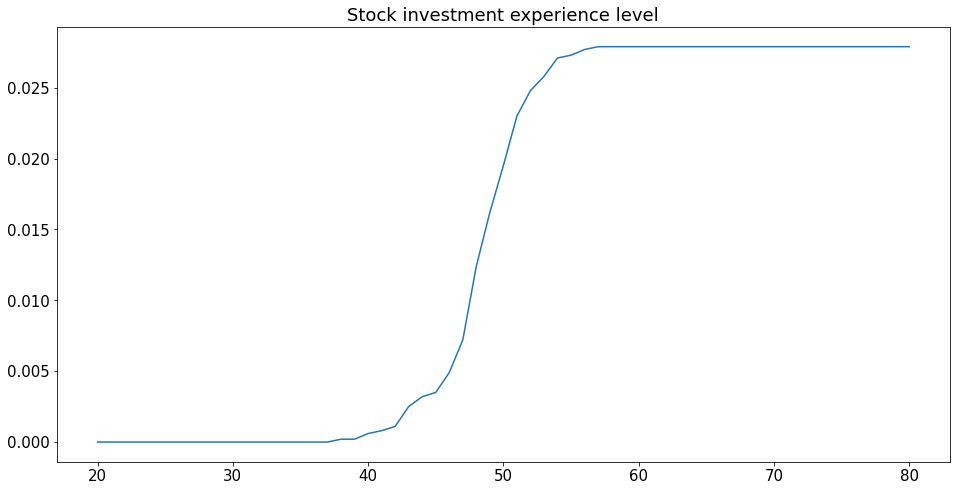

In [5]:
plt.title("Stock investment experience level")
plt.plot(range(20, T_max + 21),jnp.mean(zs,axis = 1), label = "experience")
plt.savefig("stockExperience")

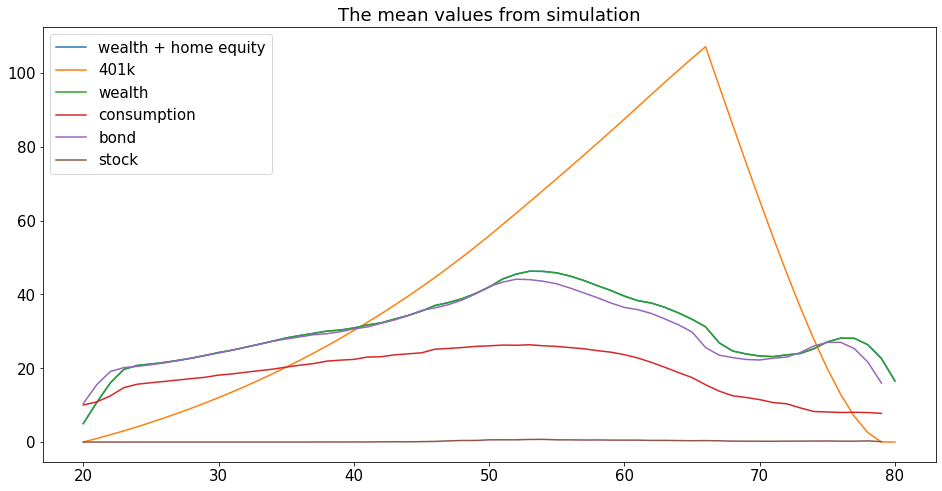

In [6]:
plt.title("The mean values from simulation")
plt.plot(range(20, T_max + 21),jnp.mean(ws + H*pt*os - ms,axis = 1), label = "wealth + home equity")
plt.plot(range(20, T_max + 21),jnp.mean(ns,axis = 1), label = "401k")
plt.plot(range(20, T_max + 21),jnp.mean(ws,axis = 1), label = "wealth")
plt.plot(range(20, T_max + 20),jnp.mean(cs,axis = 1), label = "consumption")
plt.plot(range(20, T_max + 20),jnp.mean(bs,axis = 1), label = "bond")
plt.plot(range(20, T_max + 20),jnp.mean(ks,axis = 1), label = "stock")
plt.legend()
plt.savefig("meanValueSimulation")

In [7]:
np.save("modelPoorHigh",jnp.mean(ws + H*pt*os - ms,axis = 1))

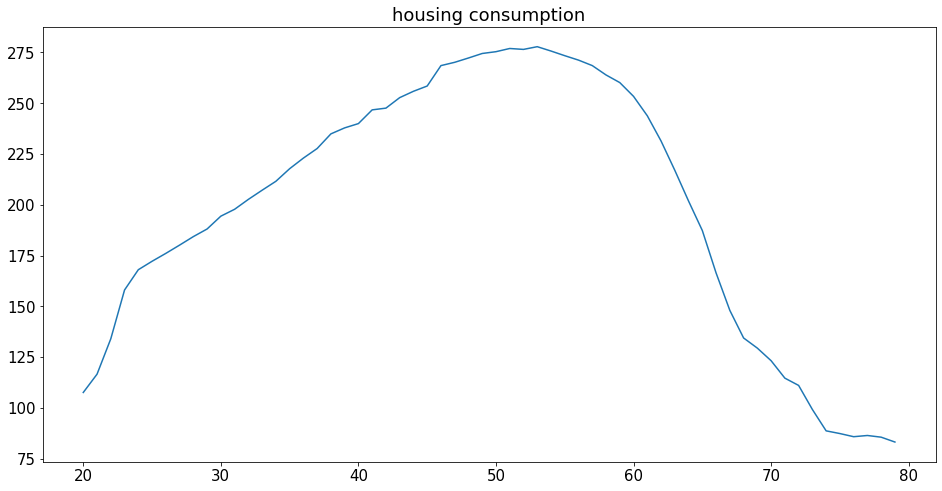

In [8]:
plt.title("housing consumption")
plt.plot(range(20, T_max + 20),(hs).mean(axis = 1), label = "housing")
plt.savefig("housingConsumption")

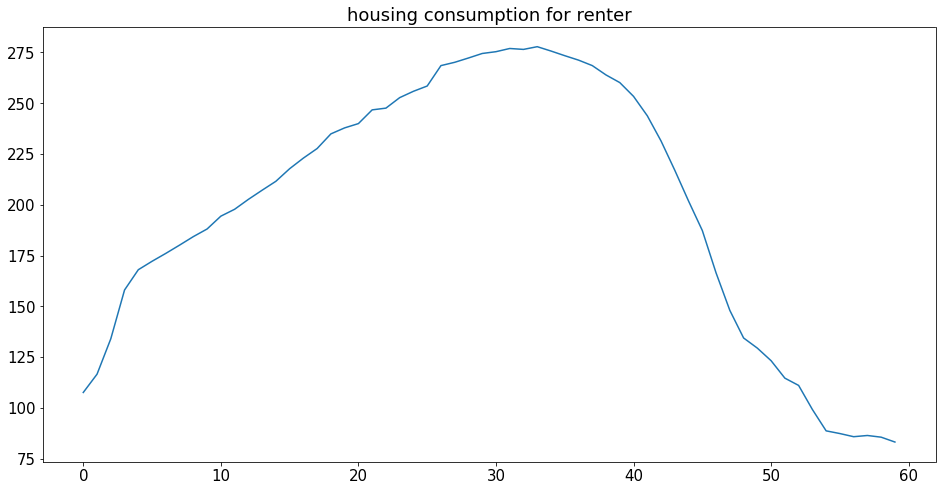

In [9]:
plt.title("housing consumption for renter")
plt.plot(hs[:, jnp.where(os.sum(axis = 0)  == 0)[0]].mean(axis = 1), label = "housing")
plt.savefig("housingConsumptionRenter")

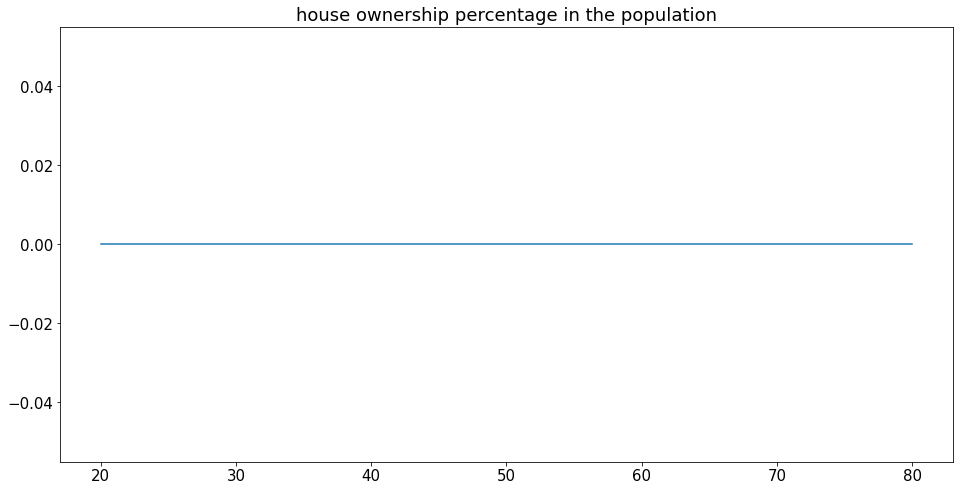

In [10]:
plt.title("house ownership percentage in the population")
plt.plot(range(20, T_max + 21),(os).mean(axis = 1), label = "owning")
plt.savefig("houseOwnership")

In [11]:
(ks/(bs+ks)).mean(axis = 1).size

60

In [12]:
(ks/(bs+ks)).mean(axis = 1)[:20].mean()

DeviceArray(3.6081747e-05, dtype=float32)

In [13]:
(ks/(bs+ks)).mean(axis = 1)[20:40].mean()

DeviceArray(0.00890404, dtype=float32)

In [14]:
(ks/(bs+ks)).mean(axis = 1)[40:].mean()

DeviceArray(0.01013728, dtype=float32)

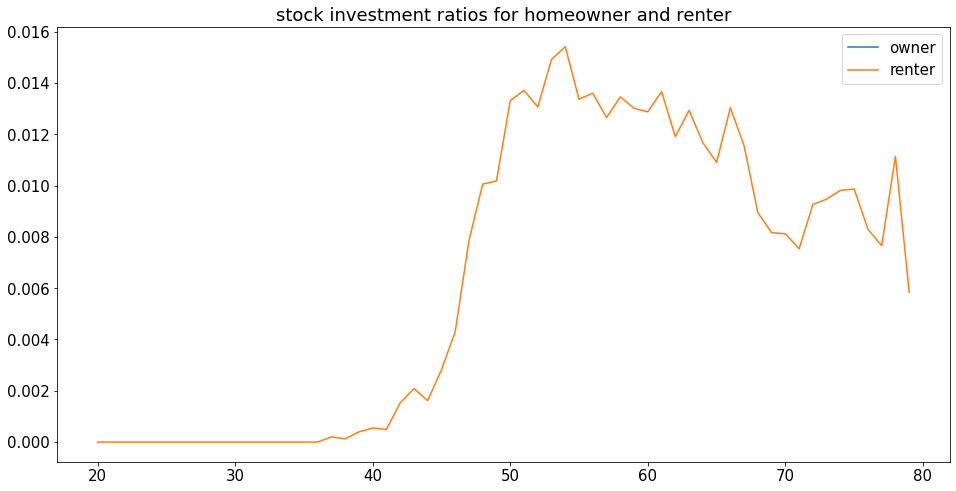

In [15]:
plt.title("stock investment ratios for homeowner and renter")
plt.plot(range(20,80), ((ks / (ks + bs))*os[1:]).sum(axis = 1)/os[1:].sum(axis =1), label = "owner")
plt.plot(range(20,80), ((ks / (ks + bs))*(1-os)[1:]).sum(axis = 1)/(1-os)[1:].sum(axis =1), label = "renter")
plt.legend()
plt.savefig("investmentRatioHomeownerRenter")

In [17]:
# # agent number, x = [w,n,m,s,e,o]
# agentNum = 35
# plt.plot(range(20, T_max + 21),(ws + os*(H*pt - ms))[:,agentNum], label = "wealth + home equity")
# plt.plot(range(20, T_max + 21),ws[:,agentNum], label = "wealth")
# plt.plot(range(20, T_max + 21),ns[:,agentNum], label = "401k")
# plt.plot(range(20, T_max + 21),ms[:,agentNum], label = "mortgage")
# plt.plot(range(20, T_max + 20),cs[:,agentNum], label = "consumption")
# plt.plot(range(20, T_max + 20),bs[:,agentNum], label = "bond")
# plt.plot(range(20, T_max + 20),ks[:,agentNum], label = "stock")
# plt.plot(range(20, T_max + 21),os[:,agentNum]*100, label = "ownership", color = "k")
# plt.legend()

In [18]:
# import pandas as pd
# investmentRatio = np.zeros((nS, T_max))
# for age in range(0,T_max):
#     stockRatio = ks[age,:] / (ks[age,:] + bs[age,:])
#     state = ss[age,:]
#     list_of_tuples = list(zip(stockRatio, state)) 
#     df = pd.DataFrame(list_of_tuples,columns = ['stockRatio', "econState"]) 
#     investmentRatio[:,age] = df.groupby("econState").mean().values.flatten()
# plt.figure()
# for age in range(1,T_max-1, 10):
#     plt.plot(investmentRatio[:,age],label = str(age + 20))
# plt.legend()

In [19]:
# age = 50
# stockRatio = ks[age,:] / (ks[age,:] + bs[age,:])
# state = ss[age,:]
# own = os[age,:]
# list_of_tuples = list(zip(stockRatio, state, own)) 
# df = pd.DataFrame(list_of_tuples,columns = ['stockRatio', "econState", "own"]) 
# owner = df[df["own"] == 1]
# renter = df[df["own"] == 0]
# plt.plot(owner.groupby("econState")["stockRatio"].mean().values.flatten(), label = "Owner")
# plt.plot(renter.groupby("econState")["stockRatio"].mean().values.flatten(), label = "Renter")
# plt.legend()

In [20]:
# agent selling time collection
agentTime = []
for t in range(30):
    if ((os[t,:] == 0) & (os[t+1,:] == 1)).sum()>0:
        for agentNum in jnp.where((os[t,:] == 0) & (os[t+1,:] == 1))[0]:
            agentTime.append([t, agentNum])
agentTime = jnp.array(agentTime)
# agent selling time collection
agentHold = []
for t in range(30):
    if ((os[t,:] == 0) & (os[t+1,:] == 0)).sum()>0:
        for agentNum in jnp.where((os[t,:] == 0) & (os[t+1,:] == 0))[0]:
            agentHold.append([t, agentNum])
agentHold = jnp.array(agentHold)

IndexError: Too many indices for array: 2 non-None/Ellipsis indices for dim 1.

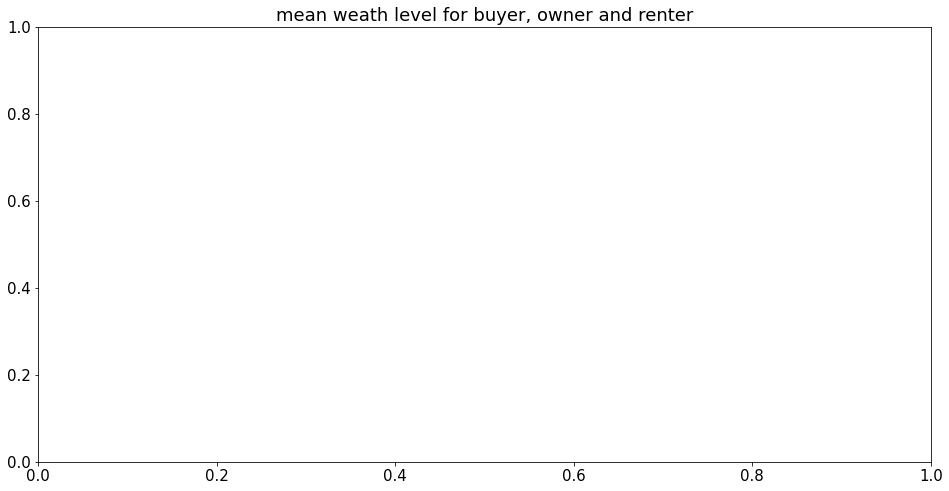

In [21]:
plt.title("mean weath level for buyer, owner and renter")
www = (os*(ws+H*pt - ms)).sum(axis = 1)/(os).sum(axis = 1)
for age in range(30):
    buyer = agentTime[agentTime[:,0] == age]
    renter = agentHold[agentHold[:,0] == age]
    bp = plt.scatter(age+20, ws[buyer[:,0], buyer[:,1]].mean(),color =  "b")
    hp = plt.scatter(age+20, www[age], color = "green")
    rp = plt.scatter(age+20, ws[renter[:,0], renter[:,1]].mean(),color =  "r")
plt.legend((bp,hp,rp), ("FirstTimeBuyer", "HomeOwner", "Renter"))
plt.savefig("wealthForBOR")

In [ ]:
plt.title("employement status for buyer and renter")
for age in range(31):
    buyer = agentTime[agentTime[:,0] == age]
    renter = agentHold[agentHold[:,0] == age]
    bp = plt.scatter(age+20, es[buyer[:,0], buyer[:,1]].mean(),color =  "b")
    rp = plt.scatter(age+20, es[renter[:,0], renter[:,1]].mean(),color =  "r")
plt.legend((bp, rp), ("FirstTimeBuyer", "Renter"))
plt.savefig("employForBAR")

In [ ]:
# agent selling time collection
agentTime = []
for t in range(T_max):
    if ((zs[t,:] == 0) & (zs[t+1,:] == 1)).sum()>0:
        for agentNum in jnp.where((zs[t,:] == 0) & (zs[t+1,:] == 1))[0]:
            agentTime.append([t, agentNum])
agentTime = jnp.array(agentTime)
# agent selling time collection
agentHold = []
for t in range(T_max):
    if ((zs[t,:] == 0) & (zs[t+1,:] == 0)).sum()>0:
        for agentNum in jnp.where((zs[t,:] == 0) & (zs[t+1,:] == 0))[0]:
            agentHold.append([t, agentNum])
agentHold = jnp.array(agentHold)

In [ ]:
plt.title("mean weath level for FirstTimeTrader, ExperiencedTrader and Inexperienced")
www = (zs*(ws+H*pt - ms)).sum(axis = 1)/(zs).sum(axis = 1)
for age in range(T_max):
    buyer = agentTime[agentTime[:,0] == age]
    renter = agentHold[agentHold[:,0] == age]
    bp = plt.scatter(age+20, ws[buyer[:,0], buyer[:,1]].mean(),color =  "b")
    hp = plt.scatter(age+20, www[age], color = "green")
    rp = plt.scatter(age+20, ws[renter[:,0], renter[:,1]].mean(),color =  "r")
plt.legend((bp,hp,rp), ("FirstTimeTrader", "ExperiencedTrader", "Inexperienced"))
plt.savefig("wealthForFEI")

In [ ]:
plt.title("employement status for FirstTimeTrader and Inexperienced")
for age in range(T_max):
    buyer = agentTime[agentTime[:,0] == age]
    renter = agentHold[agentHold[:,0] == age]
    bp = plt.scatter(age+20, es[buyer[:,0], buyer[:,1]].mean(),color =  "b")
    rp = plt.scatter(age+20, es[renter[:,0], renter[:,1]].mean(),color =  "r")
plt.legend((bp, rp), ("FirstTimeTrader", "Inexperience"))
plt.savefig("employForFI")